<a href="https://colab.research.google.com/github/VinayakMaharaj/STA365-Final-Project/blob/main/Proj_test_code_JM_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import random
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pymc as pm
import arviz as az
from pymc.math import invlogit as tt_invlogit

In [4]:
# from google.colab import files
# uploaded = files.upload() #this will prompt you to choose a file
# import io
# df = pd.read_csv(io.BytesIO(uploaded['players_are_filtered.csv']))
df = pd.read_csv('/content/players_are_filtered.csv')
#need to remove some variables we dont need for the analysis
df2 = df.iloc[:, 2:]

df3 = df2.drop(columns= ["GAME_ID", "GAME_CLOCK","SHOT_STREAK", "GAME_HALF",
                           "player_name", "player_id", "GAME_SHOTS_TAKEN",
                           "SHOT_RESULT", "REFORMATED_DEF_NAME",
                           "CLOSEST_DEFENDER_PLAYER_ID", "SEASON_SHOTS_TAKEN" ])

#remove any rows that have some kind of error
df3 = df3[df3.EXCLUDE == 0]

#no longer need exclude and fgm column
clean = df3.drop(columns= ["EXCLUDE"])

# replace 'A' with '0'
clean['LOCATION'].replace('A', 0, inplace=True)
# replace 'A' with '0'
clean['LOCATION'].replace('H', 1, inplace=True)
# when shot clock is NaN, we will replace shot clock with game clock value
clean.loc[df['SHOT_CLOCK'].isnull(),'SHOT_CLOCK'] = df['GAME_CLOCK_DECIMAL']

# print(clean.head(n=5))
# len(clean)

In [5]:
np.random.seed(23)
N = 500 #number of samples to make code run faster
samp = clean.sample(N, replace=False)

# will divide the sample dataset into 2 subdatasets
base = samp[(samp.HOT_HAND_SHOT_STREAK3 ==0) & (samp.FGM == 1)]
hot = samp[(samp.HOT_HAND_SHOT_STREAK3 ==1) & (samp.FGM == 1)]

# number of "hot hand shots taken"
print(sum(samp['HOT_HAND_SHOT_STREAK2']), 'and', sum(samp['HOT_HAND_SHOT_STREAK3']))

67.0 and 24.0


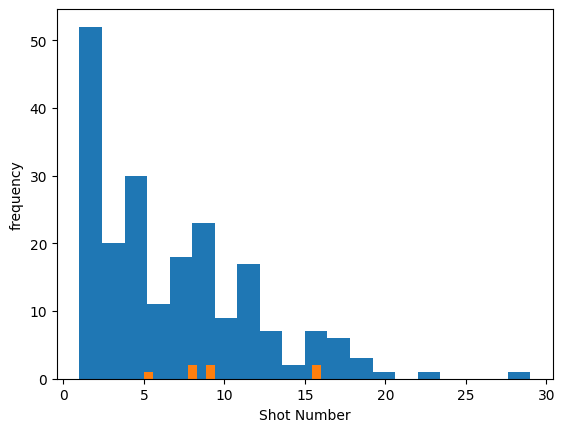

In [6]:
# Exploratory Data Analysis
plt.hist(base['SHOT_NUMBER'],bins=20)
plt.hist(hot['SHOT_NUMBER'],bins=20)
plt.xlabel('Shot Number')
plt.ylabel('frequency')
plt.show()

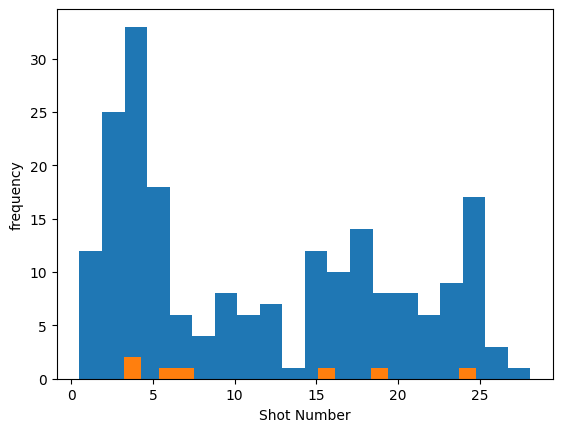

In [7]:
# Exploratory Data Analysis
plt.hist(base['SHOT_DIST'],bins=20)
plt.hist(hot['SHOT_DIST'],bins=20)
plt.xlabel('Shot Number')
plt.ylabel('frequency')
plt.show()

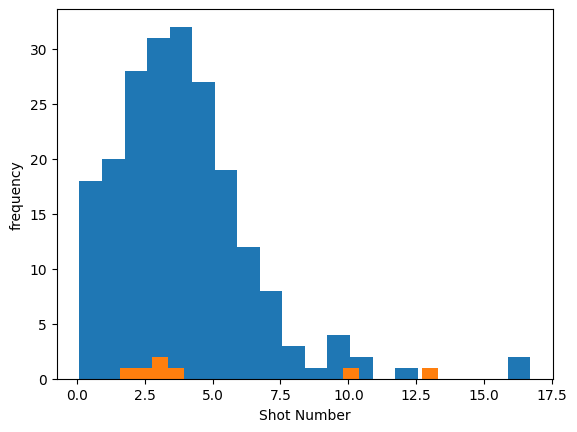

In [8]:
# Exploratory Data Analysis
plt.hist(base['CLOSE_DEF_DIST'],bins=20)
plt.hist(hot['CLOSE_DEF_DIST'],bins=20)
plt.xlabel('Shot Number')
plt.ylabel('frequency')
plt.show()

In [9]:
samp.describe()

,LOCATION,SHOT_NUMBER,PERIOD,GAME_CLOCK_DECIMAL,SHOT_CLOCK,DRIBBLES,SHOT_DIST,PTS_TYPE,DEFENDER_HEIGHT_CM,DEFENDER_WEIGHT_KG,CLOSE_DEF_DIST,FGM,PLAYER_HEIGHT,PLAYER_WEIGHT,HOT_HAND_SHOT_STREAK2,HOT_HAND_SHOT_STREAK3,GAME_TIME_ELAPSED
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000
mean,0.468000,6.928000,2.478000,5.640533,11.616367,2.004000,13.456600,2.192000,203.368320,103.905769,3.849400,0.430000,200.807320,103.477943,0.134000,0.04800,23.983467
std,0.499475,5.094971,1.155936,3.466992,6.100109,3.299357,8.387744,0.394268,8.359175,11.152283,2.389695,0.495572,8.205225,12.955533,0.340993,0.21398,14.266553
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.400000,2.000000,175.260000,78.017824,0.000000,0.000000,185.420000,78.471416,0.000000,0.00000,0.233333
25%,0.000000,3.000000,1.000000,2.729167,7.175000,0.000000,4.800000,2.000000,198.120000,97.522280,2.100000,0.000000,195.580000,96.161504,0.000000,0.00000,11.308333
50%,0.000000,6.000000,2.000000,5.575000,11.400000,1.000000,14.500000,2.000000,203.200000,104.326160,3.500000,0.000000,203.200000,104.326160,0.000000,0.00000,23.975000
75%,1.000000,10.000000,3.000000,8.454167,15.900000,2.000000,20.700000,2.000000,210.820000,112.490816,5.025000,1.000000,208.280000,111.130040,0.000000,0.00000,35.412500
max,1.000000,29.000000,6.000000,11.866667,24.000000,21.000000,34.400000,3.000000,218.440000,131.541680,16.700000,1.000000,215.900000,131.088088,1.000000,1.00000,55.483333


In [10]:
def predictor_matrix(data: pd.DataFrame, col_names: list, adjust_std=False) -> np.array:
    """
    given a dataframe <data> and list <col_names> containing p column names,
    return a numpy (N x p+1) matrix X with N observations and p
    standardized predictors (first column is the intercept column full of ones)
    if <adjust_std> == True, then use n-1 as divisor for std rather than n when
    standardizing predictors
    """
    predictors = data[col_names].to_numpy()
    normd_predictors = (predictors - np.mean(predictors, axis=0, keepdims=True)) / np.std(predictors, axis=0, keepdims=True, ddof=adjust_std)
    return np.insert(normd_predictors, 0, 1, axis=1)

In [11]:
# model 1
# list of column names you want to keep to use as predictors:
col_names1 = ['LOCATION', 'SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK_DECIMAL',
            'SHOT_CLOCK', 'DRIBBLES', 'SHOT_DIST', 'DEFENDER_HEIGHT_CM',
             'DEFENDER_WEIGHT_KG', 'CLOSE_DEF_DIST', 'PLAYER_HEIGHT',
             'PLAYER_WEIGHT', 'HOT_HAND_SHOT_STREAK3']
X1 = predictor_matrix(samp, col_names1)
P1 = X1.shape[1] - 1

In [12]:
# model 2

col_names2 = ['LOCATION', 'SHOT_CLOCK', 'SHOT_DIST', 'DEFENDER_HEIGHT_CM',
              'DEFENDER_WEIGHT_KG', 'CLOSE_DEF_DIST', 'PLAYER_HEIGHT',
              'PLAYER_WEIGHT', 'HOT_HAND_SHOT_STREAK3']
X2 = predictor_matrix(samp, col_names2)
P2 = X2.shape[1] - 1

In [13]:
y2 = np.zeros((N,1))
y2[:,0] = samp['FGM']

In [14]:
import pymc as pm; import numpy as np
#model 1
with pm.Model() as MLR:
    betas = pm.MvNormal('betas', mu= np.zeros((P1+1,1)), cov=np.eye(P1+1), shape=(P1+1,1))
    y = pm.Bernoulli('y', logit_p = pm.math.dot(X1, betas), observed = y2)
with MLR:
    idata = pm.sample()

# do more analysis / visualizations

HMC Split-Rhats {'betas': array([[0.99977637, 1.00604105, 0.99947019, 1.00111818, 1.00029931,
        1.00028465, 1.00321156, 1.00028281, 1.00029194, 1.00171473,
        1.00116447, 1.00244949, 0.99973766, 1.0027655 ],
       [1.00366437, 0.99950974, 0.99984219, 1.00254933, 1.002047  ,
        1.00285122, 0.99949245, 1.00209546, 1.00139753, 1.0001569 ,
        0.99950558, 1.00159048, 1.00042187, 1.00034592],
       [0.99944844, 1.00207016, 1.00001906, 1.0010198 , 0.99971055,
        1.00038732, 1.00120337, 1.00234351, 1.00215928, 1.00036249,
        0.99944148, 1.00029403, 1.00125345, 1.00105837],
       [1.00003174, 1.00242212, 0.99961058, 1.00121323, 1.00012315,
        0.99935311, 1.00069537, 1.00024171, 1.00274022, 1.00011539,
        1.0002354 , 1.00049187, 1.00005711, 1.00209485],
       [0.99996608, 1.00037162, 0.99984561, 1.00124536, 1.00149969,
        1.00065644, 1.00740811, 1.00102369, 1.00150809, 1.00732066,
        0.99953015, 1.00248459, 1.00091547, 1.00102932],
       [1

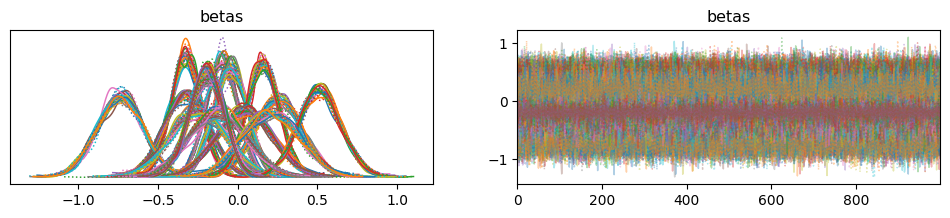

In [17]:
import arviz as az; import matplotlib.pyplot as plt;
az.plot_trace(idata);
print("HMC Split-Rhats", {k: np.round(v.values,P1+1) for k,v in az.rhat(idata).items()}, end=' | ')
# None of the split R hats values is greater than 1.05 and there is no sign of divergence.

In [ ]:
import pymc as pm; import numpy as np
from pymc.math import invlogit as tt_invlogit
#model 2
with pm.Model() as MLR:
    #LKJ cov
    packed_L = pm.LKJCholeskyCov("packed_L", n= P2+1, eta=2.0, sd_dist=pm.HalfCauchy.dist(beta=10, shape=P2+1), compute_corr=False)
    L = pm.expand_packed_triangular(P2+1, packed_L);
    Sigma = pm.Deterministic('Sigma', L.dot(L.T))

    #Horsehoe prior to help distinguish useful predictors
    tau_0 = 0.03;
    tau = pm.HalfCauchy('tau', beta=tau_0, shape=1)
    lambdas = pm.HalfCauchy('lambdas', beta=1, shape=(P2+1));
    weights = pm.Normal('weights', mu=0, sigma=tau*lambdas, shape=(P2+1))
    betas = pm.MvNormal('betas', mu= np.zeros((P2+1,1)), cov= Sigma, shape=(P2+1))

    y = pm.Bernoulli('y', logit_p = pm.math.dot(X2, betas*weights), observed = y2)
with MLR:
    MH = pm.Metropolis([betas], S=np.array([0.1]), tune=False, tune_interval=0)
    idata_MH = pm.sample(step=MH)

    #for proj we can make note on how long it takes computationally to use chol

/usr/local/lib/python3.10/dist-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()


ValueError: Not enough samples to build a trace.

In [18]:
import pymc as pm; import numpy as np
from pymc.math import invlogit as tt_invlogit

#model 3
with pm.Model() as MLR:

    #Horsehoe prior to help distinguish useful predictors
    tau_0 = 1;
    tau = pm.HalfCauchy('tau', beta=tau_0, shape=1)
    lambdas = pm.HalfCauchy('lambdas', beta=1, shape=(P2+1));
    weights = pm.Normal('weights', mu=0, sigma=tau*lambdas, shape=(P2+1))
    betas = pm.MvNormal('betas', mu= np.zeros((P2+1,1)), cov= np.eye(P2+1), shape=(P2+1))

    y = pm.Bernoulli('y', logit_p = pm.math.dot(X2, betas*weights), observed = y2)
with MLR:
    idata = pm.sample()

HMC Split-Rhats {'weights': array([1.83594259, 1.00199669, 1.00131433, 1.83353539, 1.00445626,
       1.00076047, 1.82782845, 1.83660653, 1.0049397 , 1.83480924]), 'betas': array([[1.82684605, 1.00157817, 1.00070714, 1.82878261, 1.0016206 ,
        1.00251162, 1.82784125, 1.82958758, 1.00264335, 1.8336881 ],
       [1.44724861, 0.99923314, 1.00034774, 1.45947761, 1.00476829,
        1.00351213, 1.43099021, 1.4781184 , 1.00677134, 1.4636677 ],
       [1.77533879, 1.00107435, 1.00568665, 1.77338675, 0.99989485,
        0.99999747, 1.78298606, 1.76218535, 1.00276994, 1.77410988],
       [1.83139575, 1.00053506, 1.0006521 , 1.82805941, 1.00197814,
        1.00152132, 1.82691758, 1.83209953, 1.0026675 , 1.83027932],
       [1.0030972 , 1.00064328, 0.99949323, 1.00367048, 1.00127321,
        1.00104058, 1.00553815, 1.00250431, 1.00130397, 1.00058387],
       [1.56721892, 0.99974322, 0.9995971 , 1.5791471 , 1.00352277,
        1.00005288, 1.60257528, 1.54495152, 1.00061773, 1.56414242],
     

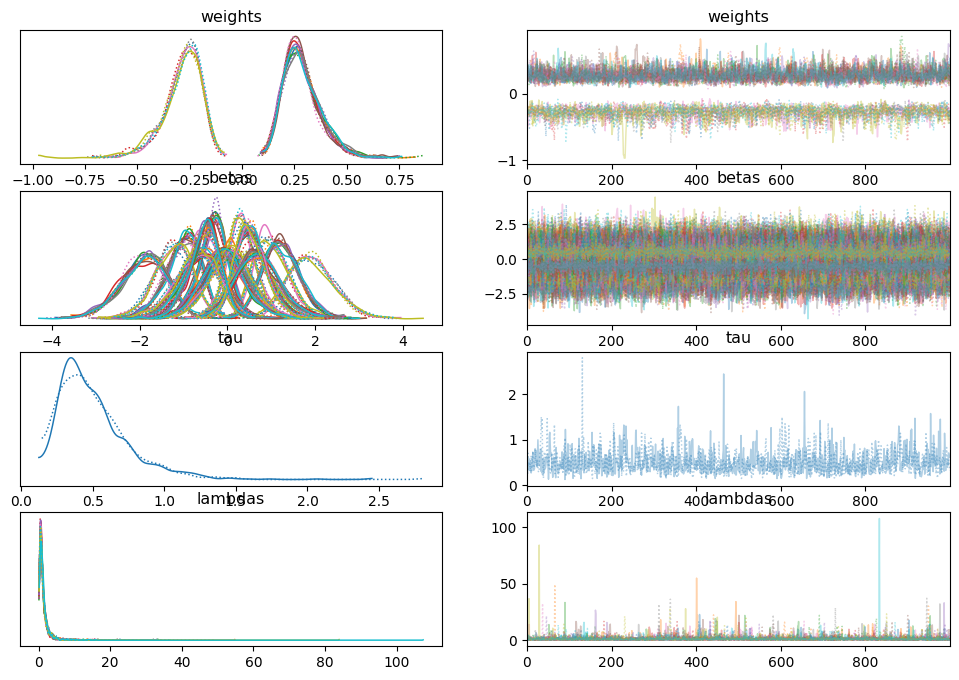

In [19]:
import arviz as az; import matplotlib.pyplot as plt;
az.plot_trace(idata);
print("HMC Split-Rhats", {k: np.round(v.values,P2+1) for k,v in az.rhat(idata).items()}, end=' | ')
# None of the split R hats values is greater than 1.05 and there is no sign of divergence.

                mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
weights[0]    -0.242  0.072  -0.381   -0.125      0.003    0.002     672.0   
weights[1]     0.001  0.251  -0.352    0.362      0.171    0.142       3.0   
weights[2]     0.244  0.073   0.120    0.378      0.003    0.002     536.0   
weights[3]     0.246  0.072   0.126    0.373      0.003    0.002     632.0   
weights[4]     0.243  0.070   0.119    0.372      0.003    0.002     675.0   
...              ...    ...     ...      ...        ...      ...       ...   
betas[13, 9]   0.006  0.768  -1.278    1.378      0.466    0.373       3.0   
betas[13, 10] -0.618  0.410  -1.368    0.150      0.008    0.007    2437.0   
betas[13, 11]  0.631  0.425  -0.120    1.483      0.009    0.008    2212.0   
betas[13, 12] -0.021  0.747  -1.281    1.226      0.452    0.362       3.0   
betas[13, 13] -0.001  0.766  -1.341    1.293      0.459    0.366       3.0   

               ess_tail  r_hat  
weights[0]       1061.0   1.00

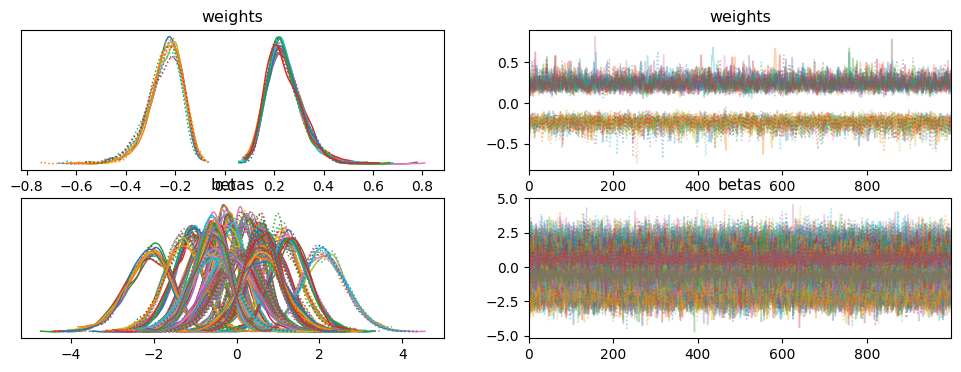

/usr/local/lib/python3.10/dist-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (210) in plot_posterior, generating only 40 plots
  warnings.warn(


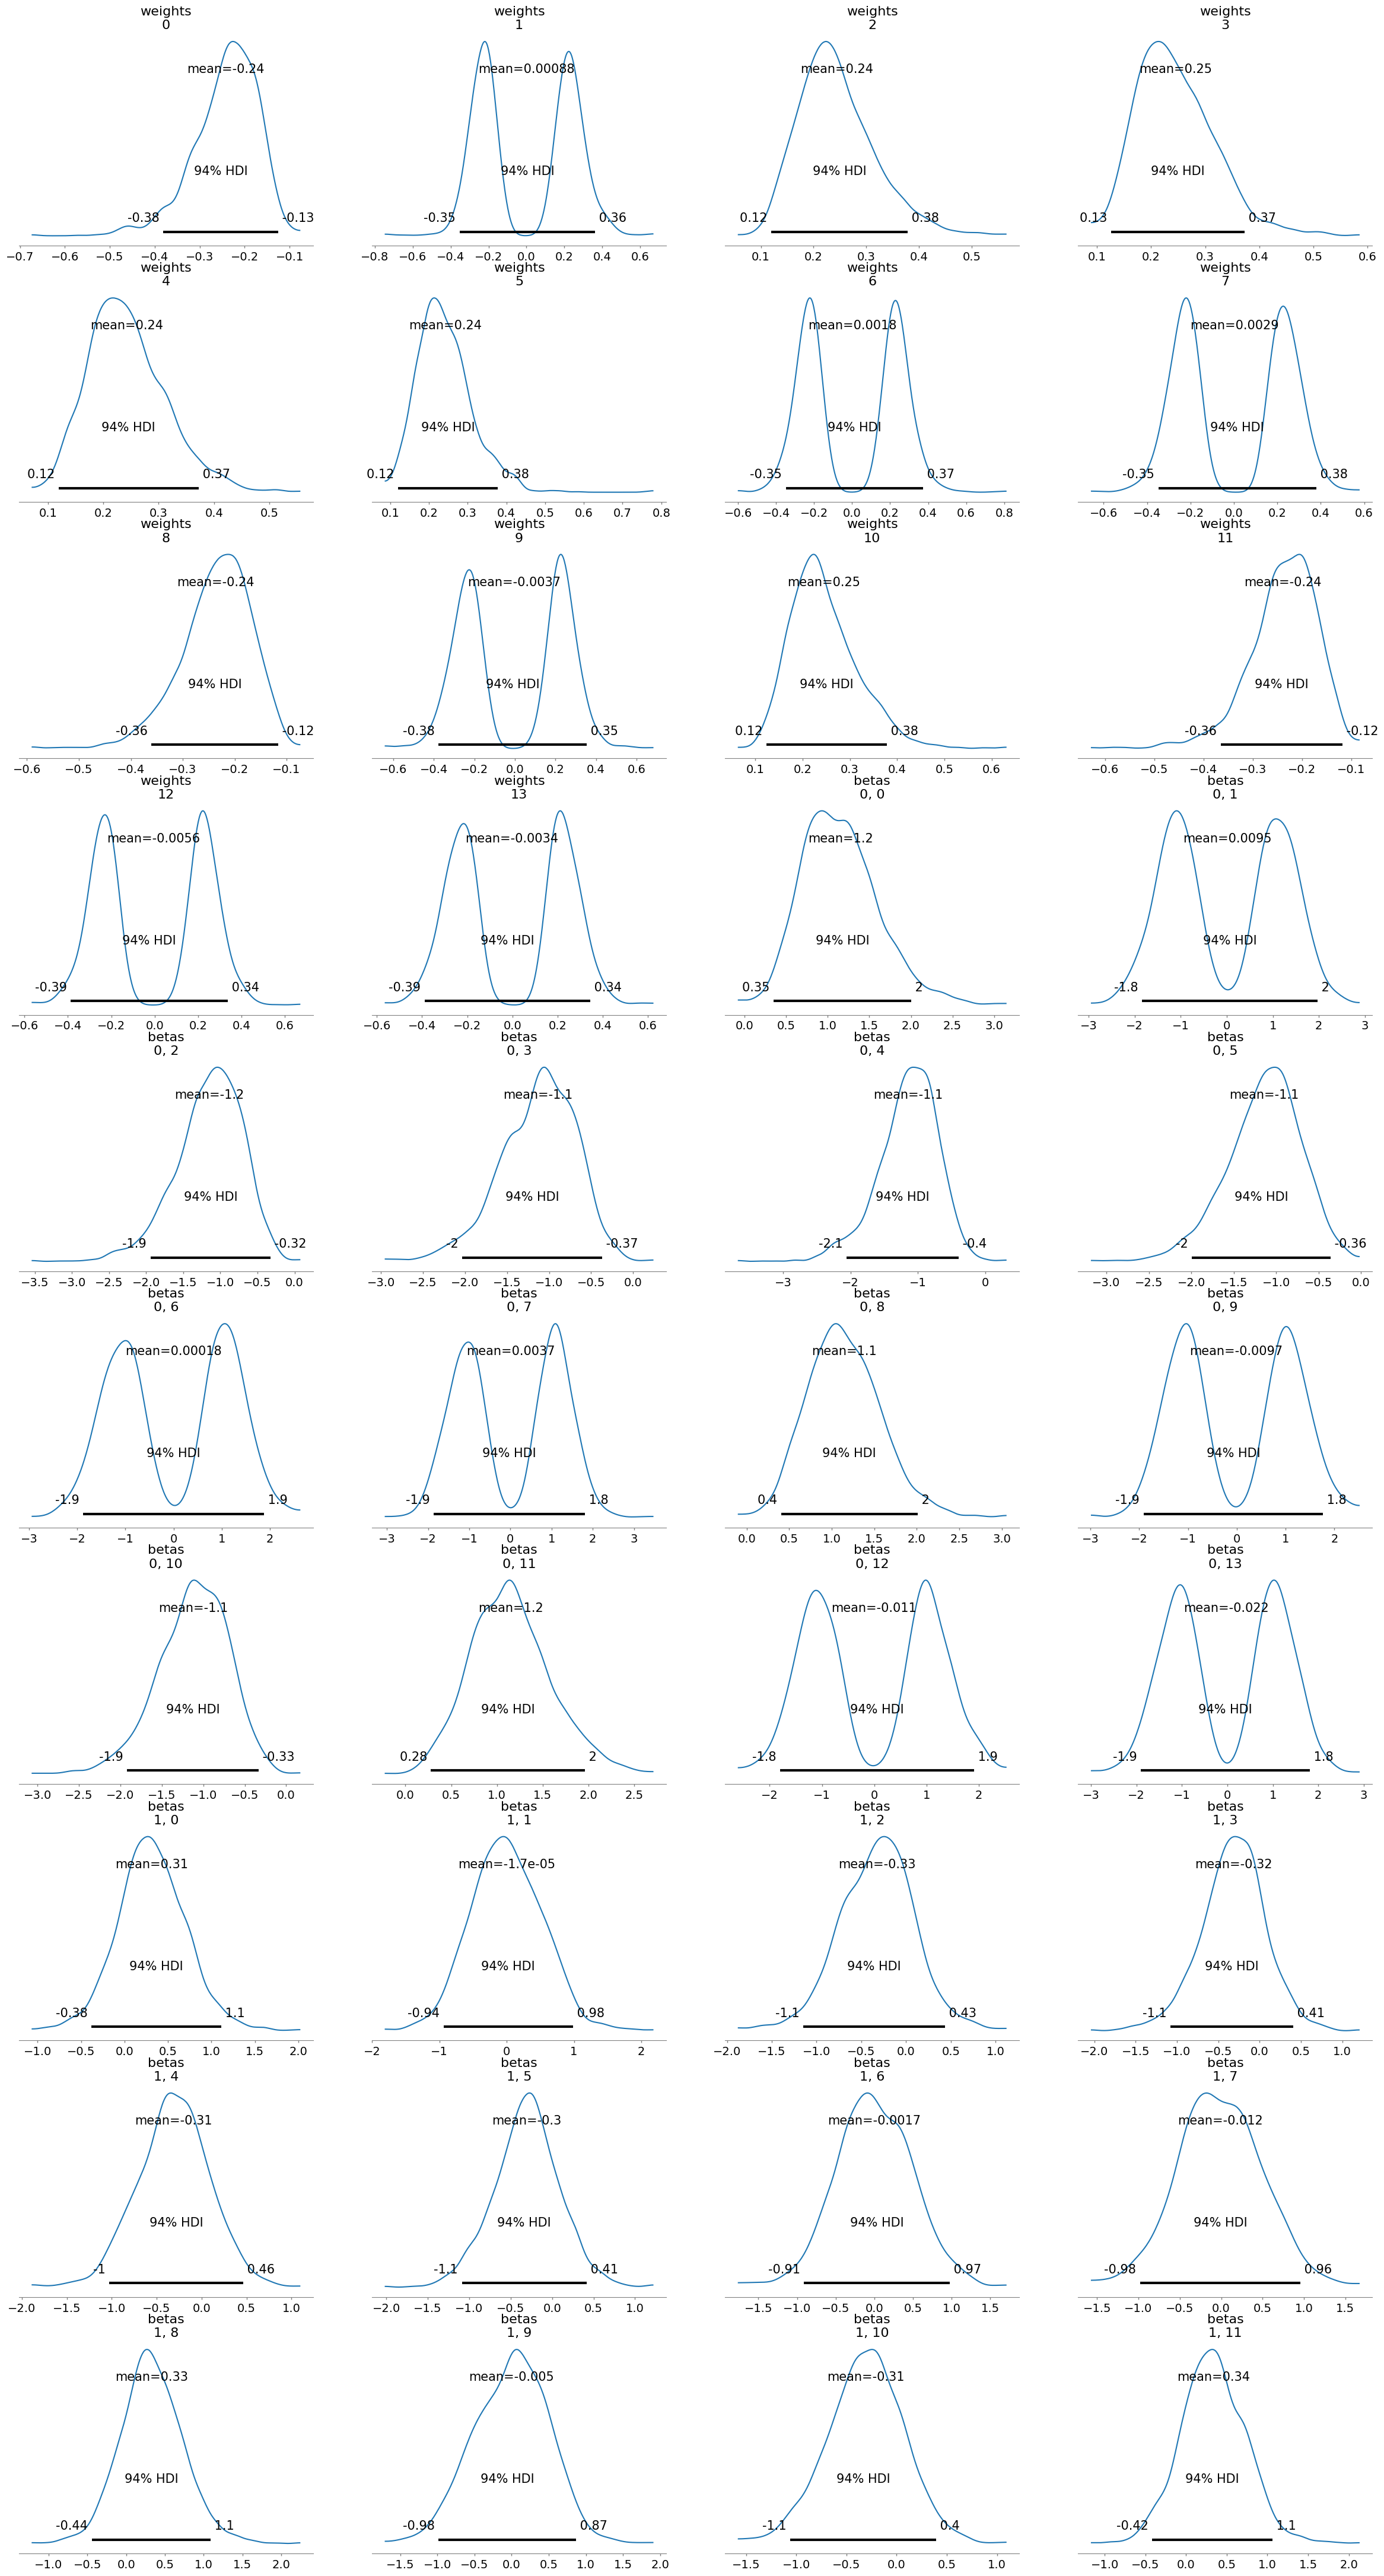

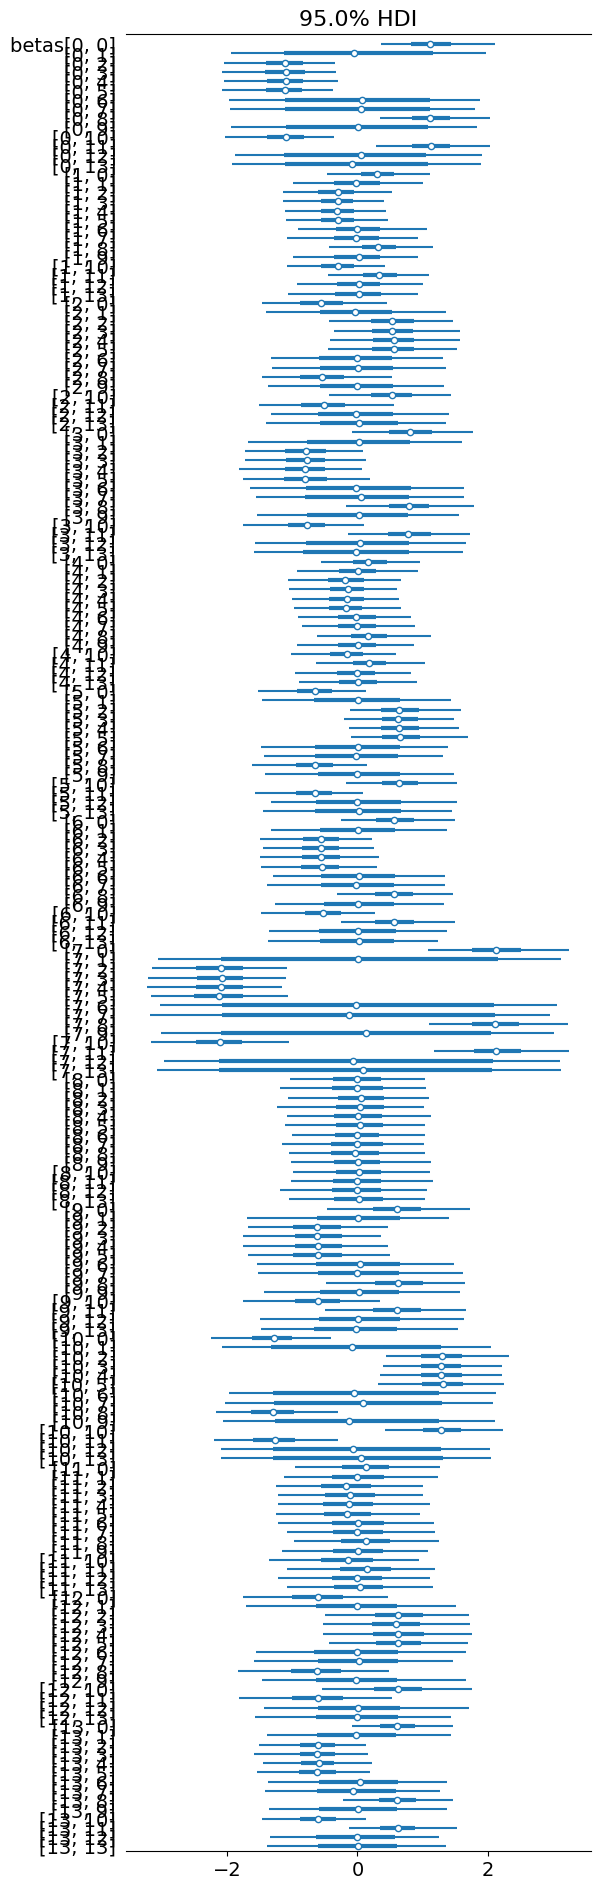

/usr/local/lib/python3.10/dist-packages/arviz/plots/backends/matplotlib/pairplot.py:232: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  warnings.warn(


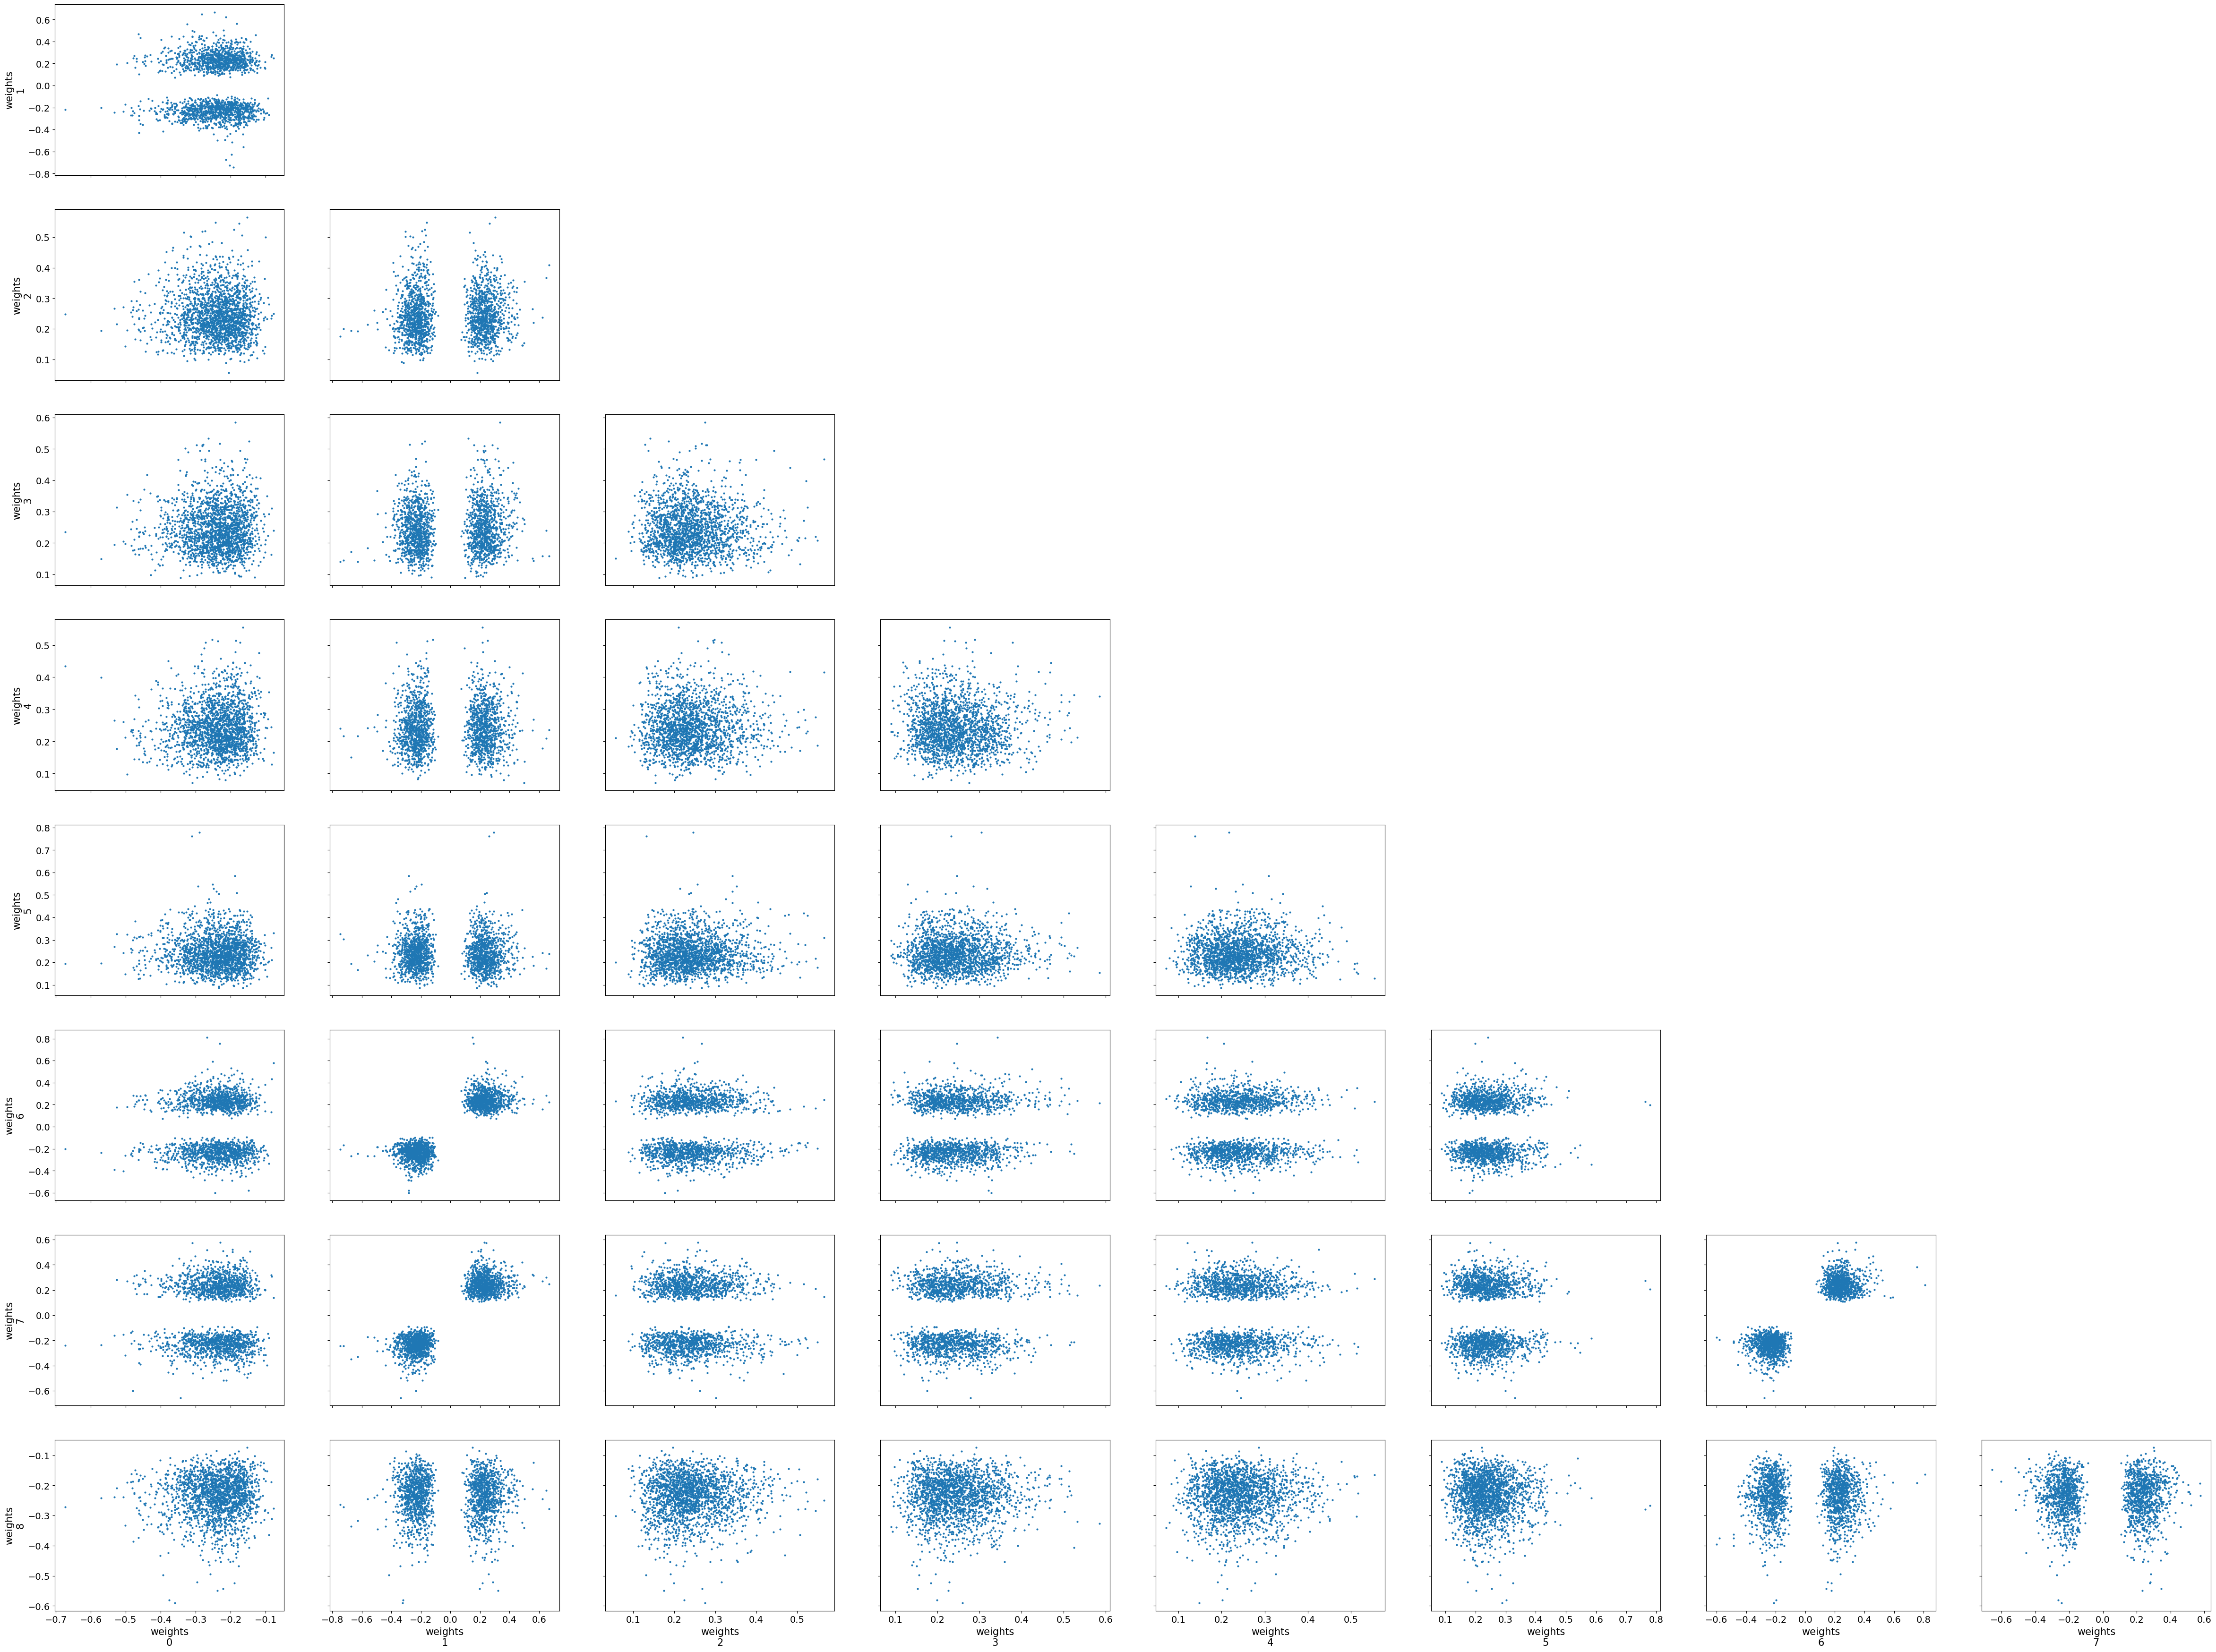

In [20]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from pymc.math import invlogit as tt_invlogit

# Assuming 'samp' DataFrame is already loaded and preprocessed
# Define the number of predictors and prepare your predictors matrix 'X' as done previously

# Model definition
P = 13  # Number of predictors

with pm.Model() as MLR:
    # Horsehoe prior for distinguishing useful predictors
    tau_0 = 1
    tau = pm.HalfCauchy('tau', beta=tau_0, shape=1)
    lambdas = pm.HalfCauchy('lambdas', beta=1, shape=(P+1))
    weights = pm.Normal('weights', mu=0, sigma=tau*lambdas, shape=(P+1))
    betas = pm.MvNormal('betas', mu=np.zeros((P+1, 1)), cov=np.eye(P+1), shape=(P+1))

    # Define the observed variable
    y = pm.Bernoulli('y', logit_p=pm.math.dot(X1, betas*weights), observed=y2)

    # Sampling
    idata = pm.sample(return_inferencedata=True)

# Analysis and Visualization
# Summary statistics
summary = az.summary(idata, var_names=['weights', 'betas'])
print(summary)

# Trace plot
az.plot_trace(idata, var_names=['weights', 'betas'])
plt.show()

# Posterior plot
az.plot_posterior(idata, var_names=['weights', 'betas'])
plt.show()

# Forest plot for betas
az.plot_forest(idata, var_names=['betas'], combined=True, hdi_prob=0.95)
plt.show()

# Pair plot for exploring relationships between parameters
az.plot_pair(idata, var_names=['weights', 'betas'])
plt.show()
